In [3]:
!pip install torch==1.10.0+cu113 torchvision torchaudio torchtext -f https://download.pytorch.org/whl/torch_stable.html

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git


Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |██████████████▋                 | 834.1 MB 2.1 MB/s eta 0:07:51tcmalloc: large alloc 1147494400 bytes == 0x3a09e000 @  0x7f4c8f6ce615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |██████████████████▌             | 1055.7 MB 30.1 MB/s eta 0:00:26tcmalloc: large alloc 1434370048 bytes == 0x7e6f4000 @  0x7f4c8f6ce615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |███████████████████████▌        | 1336.2 MB 1.7 MB/s eta 0:04:48tcmalloc: large alloc 1792966656 bytes 

     |████████████████████████████████| 7.9 MB 5.4 MB/s 
     |████████████████████████████████| 3.5 MB 5.2 MB/s 


In [4]:
!pip install node2vec

  Created wheel for node2vec: filename=node2vec-0.4.3-py3-none-any.whl size=5980 sha256=11340213344abce7468271771af68da1c1c63e372faf492ac94a821460e6200d
  Stored in directory: /root/.cache/pip/wheels/07/62/78/5202cb8c03cbf1593b48a8a442fca8ceec2a8c80e22318bae9
Successfully built node2vec


## Load Libraries


In [112]:
import networkx as nx
import torch
import pandas as pd
import numpy as np
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt  

from torch_geometric.data import Data
from torch_geometric.data import InMemoryDataset
import torch_geometric.transforms as T
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from torch.nn import Linear
from node2vec import Node2Vec

from sklearn.model_selection import train_test_split
from  sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Dataset

In [113]:
#edge list
email_graph = pd.read_csv("email-Eu-core.txt", sep = " ", header = None, names = ["person1","person2"])


In [114]:
#labels
email_label = pd.read_csv("email-Eu-core-department-labels.txt", sep = " ", header = None, names = ["person","department"])
#graph
email_graph = nx.from_pandas_edgelist(email_graph, source = "person1", target = "person2", create_using =nx.DiGraph())

In [115]:
'''
another way to have the graph. Useful to understand that
graph is directed!
import csv
from tqdm import tqdm
G = nx.DiGraph()
with open('email-Eu-core.txt', 'r') as f:
    data = csv.reader(f)
    for row in tqdm_notebook(data):
      x = row[0].split()
      G.add_edge(int(x[0]), int(x[1]))
'''


"\nanother way to have the graph. Useful to understand that\ngraph is directed!\nimport csv\nfrom tqdm import tqdm\nG = nx.DiGraph()\nwith open('email-Eu-core.txt', 'r') as f:\n    data = csv.reader(f)\n    for row in tqdm_notebook(data):\n      x = row[0].split()\n      G.add_edge(int(x[0]), int(x[1]))\n"

## Handle the data

In [116]:
#array with the labels of each node
labels = np.asarray(email_label["department"])

In [117]:
#number of total classes
num_classes = len(email_label["department"].unique())

In [118]:
#adjacency list that explains connection of our graph, coordinate format
adj = nx.to_scipy_sparse_matrix(email_graph).tocoo()

#rows of adj matrix will be source list of the nodes
row = torch.from_numpy(adj.row.astype(np.int64)).to(torch.long)

#cols of adj matrix will be target list of the nodes
col = torch.from_numpy(adj.col.astype(np.int64)).to(torch.long)

#2-dim tensor in which I have all the connections
edge_index = torch.stack([row, col], dim=0)


## Features

In [119]:
#list in which each element i is the degree of i-th node
degree = (list(dict(email_graph.degree()).values()))

#list in which each element i is the betweenness centrality of i-th node
betweenness = list(dict(nx.betweenness_centrality(email_graph)).values())

#list in which each element i is the closeness centrality of i-th node
close = list(dict(nx.closeness_centrality(email_graph)).values())

#list in which each element i is the eigenvector centrality of i-th node
#measure of prestige of a node, like rich get richer
eigen = list(dict(nx.eigenvector_centrality(email_graph)).values())

#feature vector
embeddings_centrality = list(zip(degree, betweenness, close, eigen))

#scale the feature vector
scale = StandardScaler()
#learn the scaling factor and scale the data. We have 4 features
embeddings_centrality = scale.fit_transform(np.array(embeddings_centrality).reshape(-1,4))

In [120]:
# Precompute probabilities and generate walks
node2vec = Node2Vec(email_graph, dimensions=64, walk_length=60, num_walks=20, workers = 3)

# Embed nodes
model = node2vec.fit(window=10, min_count=1, batch_words=4)

#Embeddings 
embeddings_node2vec = (model.wv.vectors)

Computing transition probabilities:   0%|          | 0/1005 [00:00<?, ?it/s]

In [121]:
# Look for most similar nodes
#model.wv.most_similar('2')  # Output node names are always strings

In [122]:
#custom dataset
#dataset is small, so data fits in the memory
class EmailDataset(InMemoryDataset):
  def __init__(self, embeddings, transform = None):

    #father, self is the instance of the class itself
    super(EmailDataset, self).__init__(".", transform, None, None)

    #data is composed by our edge index
    data = Data(edge_index=edge_index)

    #attributes of our data: number of nodes
    data.num_nodes = email_graph.number_of_nodes()

    #attributes of our data: feature vector
    data.x = torch.from_numpy(embeddings).type(torch.float32)

    #labels
    y = torch.from_numpy(labels).type(torch.long)

    #associate the labels to our data, not training of labels
    #detach for efficiency reason
    data.y = y.clone().detach()

    #associate the number of classes
    data.num_classes = num_classes

    #split in train and test
    X_train, X_test, y_train, y_test = train_test_split(pd.Series(email_graph.nodes()), pd.Series(labels), 
                                                        test_size = 0.2, random_state = 42)
    
    #split in train and validation
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

    #number of nodes
    n_nodes = email_graph.number_of_nodes()

    #we cannot just split the set since we have a graph, we have boolean
    train_mask = torch.zeros(n_nodes, dtype = torch.bool)
    test_mask = torch.zeros(n_nodes, dtype = torch.bool)
    val_mask = torch.zeros(n_nodes, dtype = torch.bool)

    #element in train/val/test will be set to true, the rest zero.
    #It is a mask indeed
    train_mask[X_train.index] = True
    test_mask[X_test.index] = True
    val_mask[X_val.index] = True

    #associate the masks to my data object
    data["train_mask"] = train_mask
    data["test_mask"] = test_mask
    data["val_mask"] = val_mask

    #object related the class, we have just one graph
    self.data, self.slices = self.collate([data])

In [123]:
#a dataset for each embedding
#difference is the length of the feature vector, in the first is 4, in the second is 64
dataset_1 = EmailDataset(embeddings_centrality)
dataset_2 = EmailDataset(embeddings_node2vec)

## Graph Neural Network

In [124]:
class Net(torch.nn.Module):
    def __init__(self, data):
        super(Net, self).__init__()
        #hidden layer
        self.hid = 8
        #head attention layer
        self.in_head = 8
        self.out_head = 1
        
        self.conv1 = GATConv(data.num_features, self.hid, heads=self.in_head)
        self.conv2 = GATConv(self.hid*self.in_head, data.num_classes, concat=False,
                             heads=self.out_head)

    #forward pass
    def forward(self, data):
      x, edge_index = data.x, data.edge_index

      #non linearity to output of first convolution
      x = F.elu(self.conv1(x, edge_index))

      #dropout some neuros during training to prevent overfitting
      x = F.dropout(x, training = self.training)

      #second convolution to previous output, every node convolves only
      #on its neighbours node 
      x = self.conv2(x, edge_index)

      #probability to belong on a class 
      return F.log_softmax(x, dim = 1)

In [125]:
#It is important to be consistent here: 
#data and model must be both on cpu or in the gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
data_1 = dataset_1[0].to(device)
data_2 = dataset_2[0].to(device)
model_1 = Net(data_1).to(device)
model_2 = Net(data_2).to(device)

cpu


In [126]:
#seed for reproducibility
torch.manual_seed(42)

#learning rate
lr = 0.1

#adam optimizer is more resilient to outliers
#it takes into account also the momentum of the gradient
optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=lr)
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=lr)

#number of epochs
epochs = 200

def train(model, data, optimizer):
  
  #training mode, to update our weights. dropout just in training mode
  model.train()

  #set the optimezer to zero every time
  optimizer.zero_grad()

  #negative log likelihood loss: compare our result with real labels.
  #item return the integer associated to the tensor
  train_loss = F.nll_loss(model(data)[data.train_mask], data.y[data.train_mask]).item()

  #negative log likelihood loss: compare our result with real labels. 
  #It compute the backward pass, compute the gradients
  F.nll_loss(model(data)[data.train_mask], data.y[data.train_mask]).backward()

  #update our weights
  optimizer.step()

  #evaluation mode
  model.eval()

  #predicition
  logits = model(data)

  train_mask = data["train_mask"]

  #predicted class on the train mask for each node
  train_pred = logits[train_mask].max(1)[1]

  #train accuracy: how many time prediction is right
  train_acc = train_pred.eq(data.y[train_mask]).sum().item() / train_mask.sum().item()

  return train_acc, train_loss

#no compute the gradient
@torch.no_grad()
def val(model, data):

  #evaluation mode
  model.eval()
  logits = model(data)

  val_mask = data["val_mask"]

  #predicted class on the validation mask for each node
  val_pred = logits[val_mask].max(1)[1]

  #val accuracy
  val_acc = val_pred.eq(data.y[val_mask]).sum().item() / val_mask.sum().item()
  
  return val_acc


@torch.no_grad()
def test(model, data):
  model.eval()
  logits = model(data)

  test_mask = data["test_mask"]

  #predicted class on the test mask for each node
  test_pred = logits[test_mask].max(1)[1]

  #test accuracy
  test_acc = test_pred.eq(data.y[test_mask]).sum().item() / test_mask.sum().item()

  #guesses
  y_true = data.y[test_mask]

  #confusion matrix
  conf = confusion_matrix(y_true, test_pred)

  #classification report
  report = classification_report(y_true, test_pred ,zero_division=1, output_dict=True)

  #report in a dataframe
  report = pd.DataFrame(report).transpose()
  
  return test_acc, conf, report


In [87]:
def run(model, data, optimizer):
  #save each training loss
  loss = []

  #save each training accuracy
  train_accuracy = []

  #save each validation accuracy
  val_accuracy = []

  #best validation accuracy
  val_acc_start = 0

  #epoch in which model reaches best validation accuracy
  best_epoch = 0
  for epoch in tqdm.notebook.tqdm(range(1,epochs+1)):

    #train the model
    train_ = train(model, data, optimizer)

    #save reached training accuracy
    train_accuracy.append(train_[0])

    #save reached training loss
    loss.append(train_[1])

    #validation accuracy 
    val_accuracy.append(val(model, data))

    #Do I improve the validation accuracy?
    if val_accuracy[-1] > val_acc_start:

      #keep in memory the best model until now
      model_best = model
      val_acc_start = val_accuracy[-1]
      best_epoch = epoch

  #using the best model for the test set 
  model = model_best
  test_acc = test(model, data)
  return loss, train_accuracy, val_acc_start, test_acc, best_epoch, val_accuracy, model

In [127]:
#run the model with Node2Vec
run_2 = run(model_2, data_2, optimizer_2)

  0%|          | 0/200 [00:00<?, ?it/s]

In [128]:
#run the model with Centrality Measures
run_1 = run(model_1, data_1, optimizer_1)

  0%|          | 0/200 [00:00<?, ?it/s]

## Results

In [130]:
#rows names
indici = ["Training loss", "Training accuracy", "Validation Accuracy", "Test accuracy", "Best epoch"]

#results: training loss, training accuracy, val accuracy, test accuracy, best epoch
result_1 = [run_1[0][-1], run_1[1][-1], run_1[2], run_1[3][0], run_1[4]]
result_2 = [run_2[0][-1], run_2[1][-1], run_2[2], run_2[3][0], run_2[4]]

#organize them in a DataFrame
result_df = pd.DataFrame(list(zip(indici, result_1, result_2)), columns = ["", "Centrality Measures", "Node2Vec"]).set_index('')
result_df


,Centrality Measures,Node2Vec
,,
Training loss,1.932681,0.655334
Training accuracy,0.548922,0.907131
Validation Accuracy,0.572139,0.746269
Test accuracy,0.457711,0.666667
Best epoch,177.000000,102.000000


## Training Accuracy

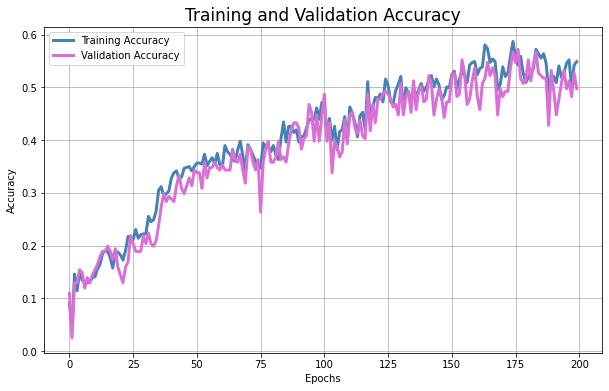

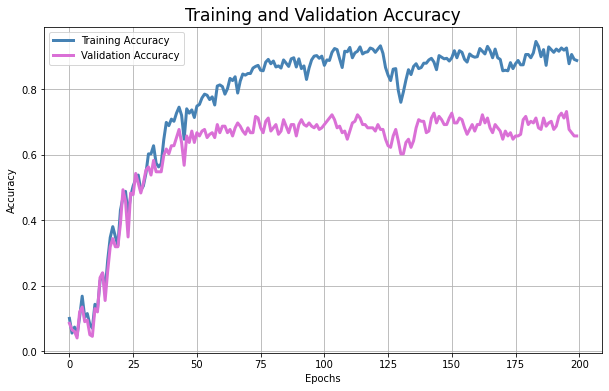

In [92]:
#plot training and validation accuracy
def plot_train_accuracy(train_acc, val_acc):
  plt.figure(figsize=(10,6))
  plt.plot(train_acc, color = "steelblue", linewidth = 3)
  plt.plot(val_acc, color = "orchid", linewidth = 3)
  plt.title("Training and Validation Accuracy", fontsize = 17)
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.grid()
  plt.legend(['Training Accuracy', 'Validation Accuracy'])
  plt.show()
plot_train_accuracy(run_1[1], run_1[5])
plot_train_accuracy(run_2[1], run_2[5])

## Training Loss

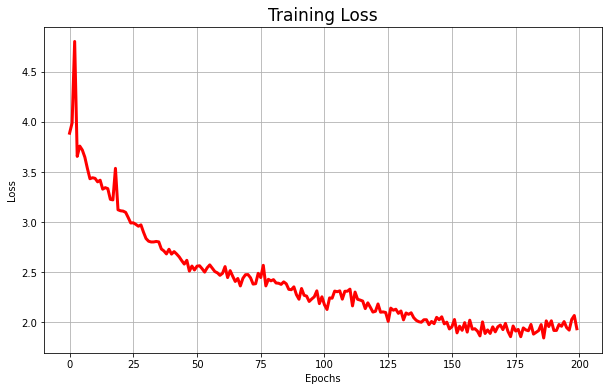

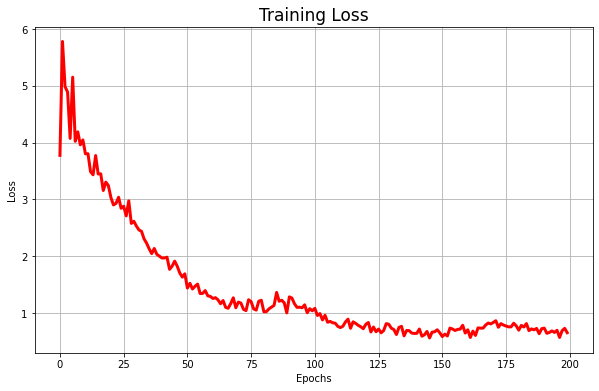

In [134]:
#plot training loss
def plot_training_loss(train_loss):
  plt.figure(figsize=(10,6))
  plt.plot(train_loss, color = "red", linewidth = 3)
  plt.title("Training Loss", fontsize = 17)
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.grid()
  plt.show()
plot_training_loss(run_1[0])
plot_training_loss(run_2[0])

## Confusion Matrix

In [ ]:
#plot confusion matrix
def confusion(test_accuracy):
  fig, ax = plt.subplots(figsize=(9,9)) 
  sns.heatmap(test_accuracy, annot=True, fmt='g', ax=ax, cmap="BuPu");  #annot=True to annotate cells, ftm='g' to disable scientific notation

  # labels, title and ticks
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels') 
  ax.set_title('Confusion Matrix')
confusion(run_1[3][1])

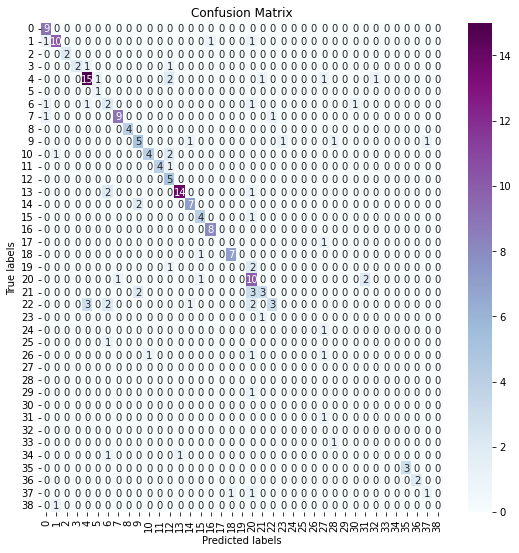

In [133]:
confusion(run_2[3][1])

## Classification Report

In [96]:
#performance metrics 
report_1= run_1[3][2]
weighted_res_1 = report_1.iloc[-1]
report_2 = run_2[3][2]
weighted_res_2 = report_2.iloc[-1]

#organize them in a Dataframe
weighted_df = pd.concat([weighted_res_1, weighted_res_2], axis = 1)
weighted_df.columns = ['Centrality Measures', 'Node2Vec']

#adding test accuracy
weighted_df = pd.concat([pd.DataFrame(result_df.iloc[-2]).T, weighted_df])
weighted_df

,Centrality Measures,Node2Vec
Test accuracy,0.457711,0.666667
precision,0.555922,0.761750
recall,0.457711,0.666667
f1-score,0.425274,0.664181
support,201.000000,201.000000


In [100]:
#performance metrics not weighted, not in the report
macro_res_1 = report_1.iloc[-2]
macro_res_2 = report_2.iloc[-2]
macro_df = pd.concat([macro_res_1, macro_res_2], axis = 1)
macro_df.columns = ['Centrality Measures', 'Node2Vec']
macro_df = pd.concat([pd.DataFrame(result_df.iloc[-2]).T, macro_df])
macro_df

,Centrality Measures,Node2Vec
Test accuracy,0.457711,0.666667
precision,0.597562,0.640314
recall,0.381923,0.562438
f1-score,0.295953,0.439348
support,201.000000,201.000000


## Bonus Point

In [101]:
# GCN model with 2 layers 
class Net(torch.nn.Module):
  def __init__(self,data):
    super(Net, self).__init__()

    #convolve information on the neighbourhood of a graph
    #two layer so aggregation up to distance 2
    self.conv1 = GCNConv(data.num_features, 32)
    self.conv2 = GCNConv(32, int(data.num_classes))

  #forward pass
  def forward(self, data):
    x, edge_index = data.x, data.edge_index

    #non linearity to output of first convolution
    x = F.relu(self.conv1(x, edge_index))

    #dropout some neuros during training to prevent overfitting
    x = F.dropout(x, training = self.training)

    #second convolution to previous output, every node convolves only
    #on its neighbours node 
    x = self.conv2(x, edge_index)

    #probability to belong on a class 
    return F.log_softmax(x, dim = 1)

In [102]:
#same as before, same functions
model_1 = Net(data_1).to(device)
model_2 = Net(data_2).to(device)
torch.manual_seed(42)
optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=lr)
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=lr)
run_2 = run(model_2, data_2, optimizer_2)
run_1 = run(model_1, data_1, optimizer_1)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

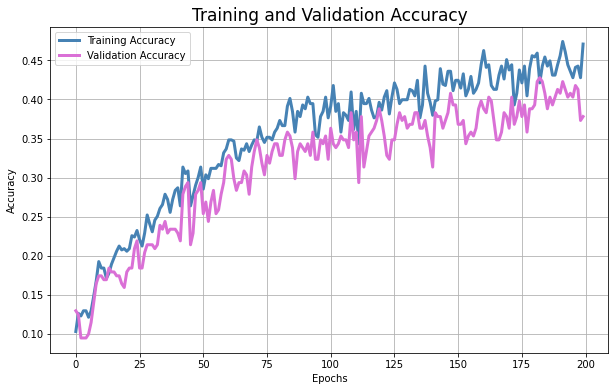

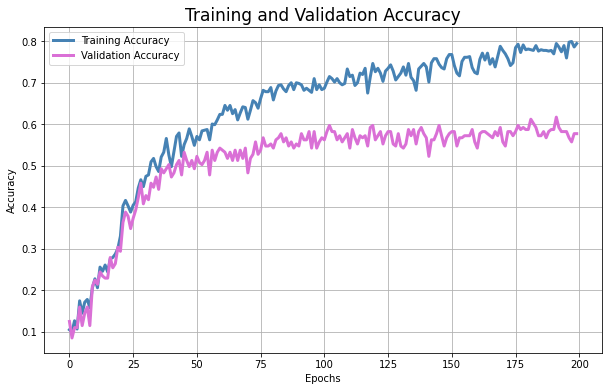

In [104]:
#plot training and validation accuracy
plot_train_accuracy(run_1[1], run_1[5])
plot_train_accuracy(run_2[1], run_2[5])

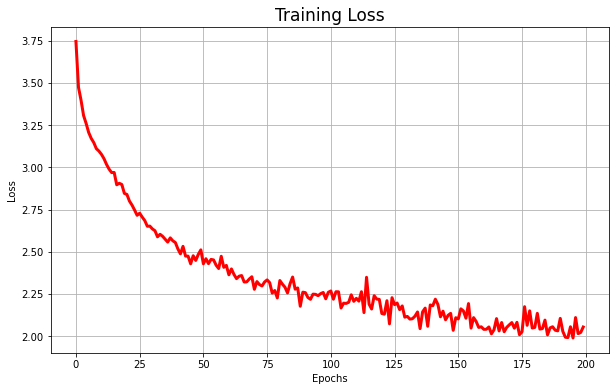

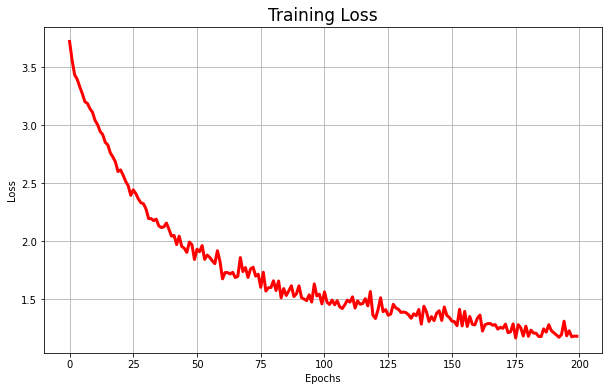

In [105]:
#plot training loss
plot_training_loss(run_1[0])
plot_training_loss(run_2[0])

In [107]:
indici = ["Training loss", "Training accuracy", "Validation Accuracy", "Test accuracy", "Best epoch"]
result_1 = [run_1[0][-1], run_1[1][-1], run_1[2], run_1[3][0], run_1[4]]
result_2 = [run_2[0][-1], run_2[1][-1], run_2[2], run_2[3][0], run_2[4]]
result_df = pd.DataFrame(list(zip(indici, result_1, result_2)), columns = ["", "Centrality Measures", "Node2Vec"]).set_index('')
result_df


,Centrality Measures,Node2Vec
,,
Training loss,2.053827,1.178211
Training accuracy,0.470978,0.794362
Validation Accuracy,0.427861,0.616915
Test accuracy,0.402985,0.616915
Best epoch,183.000000,192.000000


In [108]:
report_1= run_1[3][2]
weighted_res_1 = report_1.iloc[-1]
report_2 = run_2[3][2]
weighted_res_2 = report_2.iloc[-1]
weighted_df = pd.concat([weighted_res_1, weighted_res_2], axis = 1)
weighted_df.columns = ['Centrality Measures', 'Node2Vec']
weighted_df = pd.concat([pd.DataFrame(result_df.iloc[-2]).T, weighted_df])
weighted_df

,Centrality Measures,Node2Vec
Test accuracy,0.402985,0.616915
precision,0.568050,0.685040
recall,0.402985,0.616915
f1-score,0.371546,0.572107
support,201.000000,201.000000


In [109]:
macro_res_1 = report_1.iloc[-2]
macro_res_2 = report_2.iloc[-2]
macro_df = pd.concat([macro_res_1, macro_res_2], axis = 1)
macro_df.columns = ['Centrality Measures', 'Node2Vec']
macro_df = pd.concat([pd.DataFrame(result_df.iloc[-2]).T, macro_df])
macro_df

,Centrality Measures,Node2Vec
Test accuracy,0.402985,0.616915
precision,0.581302,0.661315
recall,0.266435,0.437704
f1-score,0.201552,0.353119
support,201.000000,201.000000


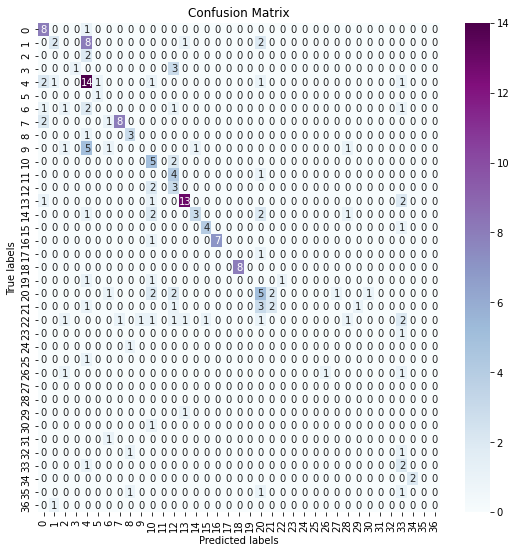

In [135]:
confusion(run_1[3][1])


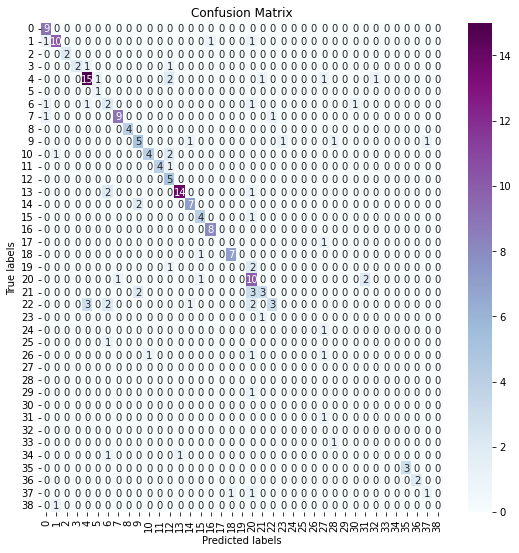

In [136]:
confusion(run_2[3][1])

## Extra Visualization (not in the report)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


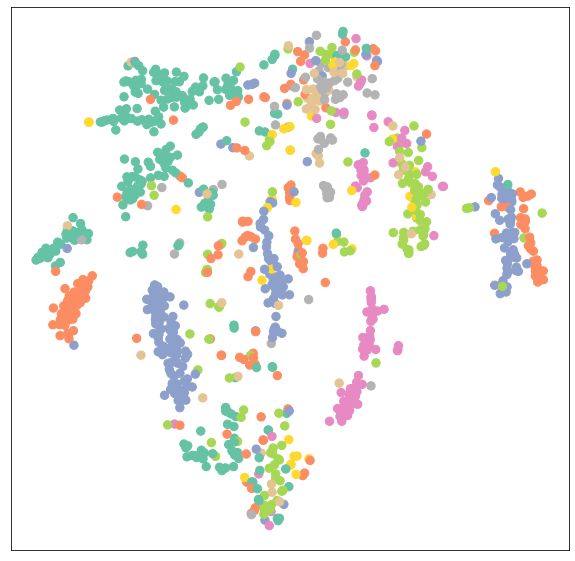

In [90]:
from sklearn.manifold import TSNE
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

mod = run_2[6]
out = mod(data_2)
visualize(out, color=data_2.y)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


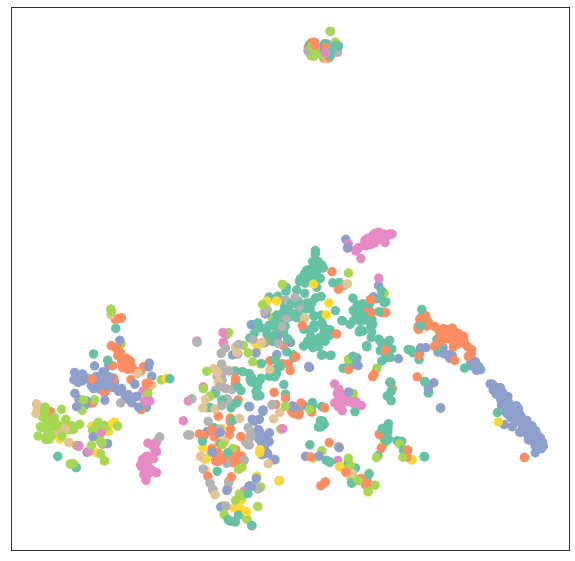

In [97]:
mod = run_1[6]
out = mod(data_1)
visualize(out, color=data_1.y)